In [2]:
import numpy as np
import datasets
import tensorflow as tf
from tensorflow.keras import activations, layers, models
import matplotlib.pyplot as plt
from parameters import Parameters
import convtas
from loss import LOGL2,SDR
import os


First thing we are going to do is to just load our data in. The data when being put through a TensorFlow should be organized in a very specific way. Right now each observation in our data is organized like this : $(2\cdot M,K,L)$

- $M$ = 100; Batch number, remember each batch observation is 2 tensors each one correlating to the left/right audio channel.
- $K$ = 40; Index/number of overlapping chunks of waveform.
- $L$ = 16; Length of a chunk/sample of data. For this study we will refer to these as chunks.

For our outputs the data is structured like: $(2\cdot M,C,K,L)$

- $C$ = 4; Denotes the source target.

In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
def make_med_dataset():
    datasets = [tf.data.Dataset.load(f'tensors/tensor_dataset_small_{i}') for i in range(10)]

    for i, data in enumerate(datasets):
        if i == 0:
            dataset = data
        else: 
            dataset = dataset.concatenate(data)
    
    dataset.save('tensors/tensor_dataset_medium')

make_med_dataset()

In [5]:
dataset = tf.data.Dataset.load(f'tensors/tensor_dataset_medium')

In [6]:
print(tf.data.experimental.cardinality(dataset).numpy())

4000


In [42]:
param = Parameters()

In [43]:
cnn = convtas.ConvTasNet(param)

In [7]:
def run_model(model, loss: str, loss_funct, dataset):
    # Create a callback that saves the model's weights every 5 epochs
    checkpoint_path = f"training_{loss}_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    
    model.compile(optimizer='adam',
              loss=loss_funct,
              metrics=['accuracy']
              )
    
    history = model.fit(dataset, epochs=10, callbacks=[cp_callback])

    return history

def create_fit_save(dataset, epochs=10):
    param = Parameters()
    cnn = convtas.ConvTasNet(param)
    hist1 = run_model(cnn, "LOGL2", LOGL2(), dataset)
    cnn = convtas.ConvTasNet(param)
    hist2 = run_model(cnn, "SDR", SDR(), dataset)
    
    return hist1, hist2
    


In [8]:
create_fit_save(dataset)

Epoch 1/10
  28/4000 [..............................] - ETA: 43:06 - loss: 1.5957 - accuracy: 0.1405

In [7]:
cnn.compile(optimizer='adam',
              loss=SDR(),
              metrics=['accuracy']
              )

In [8]:
history = cnn.fit(dataset, epochs=10)

Epoch 1/10
400/400 [==============================] - 1168s 3s/step - loss: -2.3059 - accuracy: 0.1951
Epoch 2/10
400/400 [==============================] - 1174s 3s/step - loss: -2.8136 - accuracy: 0.2347
Epoch 3/10
 74/400 [====>.........................] - ETA: 3:41 - loss: -2.9191 - accuracy: 0.2421

KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

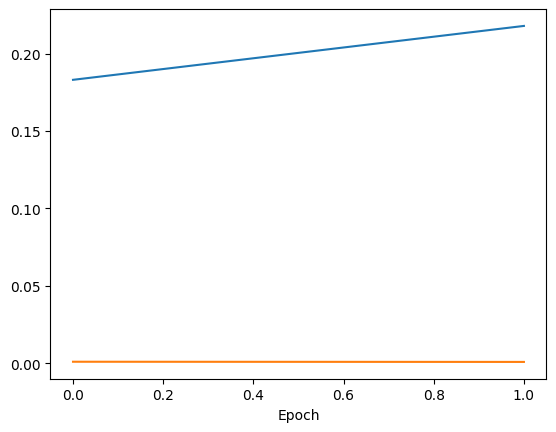

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'MSE')
plt.xlabel('Epoch')

In [8]:
class ConvTasNet(models.Model):
    """
    Full Conv-TasNet model, coded in TensorFlow. I heavily relied upon, upon Jane Wu's TensorFlow implementation (https://github.com/JaneWuNEU/Conv-TasNet-2)
    to get this to work. nplab's and kaituoxu's PyTorch implementations of the model were also instrumental for my understanding of the model.
    
    To explain what the model is doing in the most basic way, it takes a dataset of overlapping chunks of a audio in a waveform format then 
    encodes them using a simple 1D convolution. With this input data, the model is then put through several iterations of downsampling to get 
    features from the data. These features are then turned into separate masks for each target source in the audio data. Finally the masks are 
    applied to the orginal encoded data, which is finally put back into its orginal waveform data format with a Transpose 1D convolution.

    To understand the shape of the data throughout the model, I highly recommend looking at the Parameters class documentation, but I tried to 
    give documentation to the important paramters throughout the layers documentation as well. 
    """
    def __init__(self, param: Parameters):
        super().__init__(name="ConvTasNet")
        self.param = param


        self.encoder = Encoder(self.param)
        self.separator = Separator(self.param)
        self.decoder = Decoder(self.param)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        decoded = self.decoder(m_i, w)

        return decoded

In [9]:
class Encoder(layers.Layer):
    """ 
    First step of model not counting, preprocessing data. Puts the inputs through a 1x1 Convolutional layer with N output channels.
    A 1x1Convolutional layer can be interpreted and implemented as a Dense layer, but I chose not to implement it this way for clarity.
    The layer also has a ReLU activation function attached to it.

    Args: 
        N: Encoder output size

    """
    def __init__(self, param: Parameters):
        super(Encoder, self).__init__(name='Encoder')
        self.U = layers.Conv1D(param.N,1)

    def call(self, x): # (M, K, L)
        return self.U(x) # (M, K, N)

        
class Separator(layers.Layer):
    """ 
    To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
    This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
    several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
    with C*N output channels.
    Args:
        N: (int) Encoder output size
        B: (int) Conv1DBlock output size
        R: (int) Amount of repeats of the Temporal Convolution block
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        C: (int) Amount of sources being estimated
    
    """
    def __init__(self, param: Parameters):
        super(Separator, self).__init__(name='Separator')
        self.M = param.M
        self.K = param.K
        self.C = param.C
        self.N = param.N
        self.skip=param.skip
        if param.casual:
            self.normalization = cLN(param.N)
        else:
            self.normalization = gLN(N) 
        self.bottle_neck = layers.Conv1D(param.B,1)
        
        self.temporal_conv = [TemporalConv(param.X, param.H, param.B, param.P, param.casual, skip=param.skip) for r in range(param.R)]
        self.skip_conn = layers.Add()
        self.prelu = layers.PReLU()
        self.m_i = layers.Conv1D(param.C*param.N, 1)

    def call(self, w): # (M, K, N)
        normalized_w = self.normalization(w) # (M, K, N)
        output = self.bottle_neck(normalized_w) # (M, K, B)
        skip_list = []
        for i,block in enumerate(self.temporal_conv):
            if self.skip:
                output, skips = block(output)
                skip_list.append(skips)
            else:
                output = block(output)
        # (M, K, B)
        if self.skip:
            output = self.skip_conn(skip_list)

        output = self.prelu(output)
        estimated_masks = self.m_i(output) # (M, K, C*N)
        estimated_masks = activations.sigmoid(tf.reshape(estimated_masks, (self.M, self.C, self.K, self.N)))
        return estimated_masks
    
class Decoder(layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        L : (int) length of individual chunks of audio.
    """
    def __init__(self, param: Parameters):
        super(Decoder, self).__init__(name='Decoder')
        self.M = param.M
        self.K = param.K
        self.L = param.L
        self.transpose_conv = layers.Conv1DTranspose(param.L,1)

    def call(self, m_i, w):
        est_sources =[]
        for i in range(C):
            source_mask = m_i[:,i,:,:]
            masked_source = w * source_mask
            est_src = self.transpose_conv(masked_source)
            est_sources.append(tf.reshape(est_src, (self.M, 1, self.K, self.L)))

        decoded_outputs = tf.concat(est_sources, axis=1)
        return decoded_outputs    

In [34]:
# Params as globals for testing purposes
M=200
K=40
L=16 # Chunk size
C=4 # Amount of sources being estimated
N=512 # Encoder output size
B=128 # Conv1DBlock output size
H=512 # Conv1DBlock input size
P=3
R=3 # Amount of repeats of the Temporal Convolution block
X=8 # Amount of times Conv1DBlock is applied in a Temporal Convolution block
T=3000 # TODO: figure out how to get this param
dilation = 1
overlap=8
casual=False

## Overall Architecture

Looking at the model from a top down view, the data follows this pipeline:

Data ---> Encoder ----> Separator ---> Decoder ---> Create Sources

In [53]:
class ConvTasNet(models.Model):
    """
    
    """
    def __init__(self,
                 L: int=16, # Chunk size
                 C: int=4, # Amount of sources being estimated
                 N: int=512, # Encoder output size
                 B: int=128, # Conv1DBlock output size
                 H: int=512, # Conv1DBlock input size
                 P: int=3, # Kernel size of Conv1DBlocks
                 R: int=3, # Amount of repeats of the Temporal Convolution block
                 X: int=8, # Amount of times Conv1DBlock is applied in a Temporal Convolution block
                 T: int=3000, # TODO: figure out how to get this param
                 # win: int=2, # Size of encoder-decoder kernels
                 overlap: int=8,
                 skip: bool=True,
                 casual: bool=False
                ):
        super().__init__(name="ConvTasNet")
        self.L = L
        self.C = C
        self.N = N
        self.B = B
        self.H = H
        self.R = R
        self.X = X
        self.T = T
        self.P = P
        # self.win = win
        self.overlap = overlap
        self.skip = skip
        self.casual = casual


        self.encoder = Encoder(self.N)
        self.separator = Separator(self.N, self.B, self.R, self.X, self.H, self.C, self.P, self.casual, self.skip)
        self.decoder = Decoder(self.L)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        decoded = self.decoder(m_i, w)

        return decoded
    


In [54]:
cnn = ConvTasNet()
cnn_output = cnn(x_batches[0])
cnn_output.shape

TensorShape([200, 4, 40, 16])

In [59]:
cnn.summary()

Model: "ConvTasNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           multiple                  8704      
                                                                 
 Separator (Separator)       multiple                  6154368   
                                                                 
 Decoder (Decoder)           multiple                  8208      
                                                                 
Total params: 6171280 (23.54 MB)
Trainable params: 6171280 (23.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
output = np.asarray(cnn_output[0])

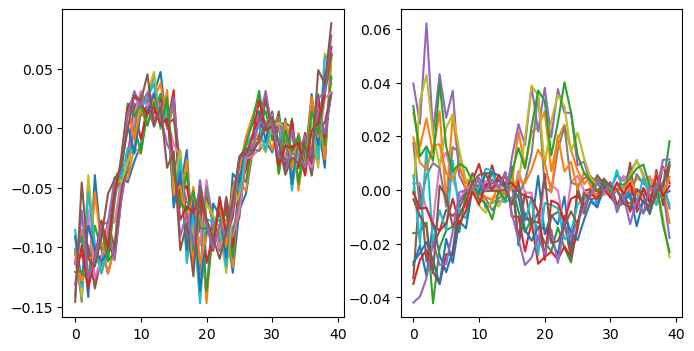

In [58]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(x_batches[0][0])
axes[1].plot(output[0])

In [50]:
class Encoder(layers.Layer):
    """ 
    First step of model not counting, preprocessing data. Puts the inputs through a 1x1 Convolutional layer with N output channels.
    A 1x1Convolutional layer can be interpreted and implemented as a Dense layer, but I chose not to implement it this way for clarity.
    The layer also has a ReLU activation function attached to it.

    Args: 
        N: Encoder output size

    """
    def __init__(self, N):
        super(Encoder, self).__init__(name='Encoder')
        self.U = layers.Conv1D(N,1)

    def call(self, x): # (M, K, L)
        return self.U(x) # (M, K, N)

        
class Separator(layers.Layer):
    """ 
    To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
    This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
    several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
    with C*N output channels.
    Args:
        N: (int) Encoder output size
        B: (int) Conv1DBlock output size
        R: (int) Amount of repeats of the Temporal Convolution block
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        C: (int) Amount of sources being estimated
    
    """
    def __init__(self, N, B, R, X, H, C, P, casual, skip=True):
        super(Separator, self).__init__(name='Separator')
        self.C = C
        self.N = N
        self.skip=skip
        if casual:
            self.normalization = cLN(N)
        else:
            self.normalization = gLN(N) 
        self.bottle_neck = layers.Conv1D(B,1)
        
        self.temporal_conv = [TemporalConv(X, H, B, P, casual, skip=self.skip) for r in range(R)]
        self.skip_conn = layers.Add()
        self.prelu = layers.PReLU()
        self.m_i = layers.Conv1D(C*N, 1)

    def call(self, w): # (M, K, N)
        normalized_w = self.normalization(w) # (M, K, N)
        output = self.bottle_neck(normalized_w) # (M, K, B)
        skip_list = []
        for i,block in enumerate(self.temporal_conv):
            if self.skip:
                output, skips = block(output)
                skip_list.append(skips)
            else:
                output = block(output)
        # (M, K, B)
        if self.skip:
            output = self.skip_conn(skip_list)

        output = self.prelu(output)
        estimated_masks = self.m_i(output) # (M, K, C*N)
        M, K, _ = estimated_masks.shape
        estimated_masks = activations.sigmoid(tf.reshape(estimated_masks, (M, self.C, K, self.N)))
        return estimated_masks
    
class Decoder(layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        L : (int) length of individual chunks of audio.
    """
    def __init__(self, L):
        super(Decoder, self).__init__(name='Decoder')
        self.L = L
        self.transpose_conv = layers.Conv1DTranspose(L,1)

    def call(self, m_i, w):
        M, C, K, _ = m_i.shape
        est_sources =[]
        for i in range(C):
            source_mask = m_i[:,i,:,:]
            masked_source = w * source_mask
            est_src = self.transpose_conv(masked_source)
            est_sources.append(tf.reshape(est_src, (M, 1, K, L)))

        decoded_outputs = tf.concat(est_sources, axis=1)
        return decoded_outputs            


In [18]:
class Conv1DBlock(layers.Layer):
    def __init__(self, H, B, P, dilation, casual, skip = True):
        super(Conv1DBlock, self).__init__(name='Conv1DBlock')
        self.skip = skip
        self.input_channels = layers.Conv1D(H,1)
        self.prelu = layers.PReLU()
        if casual:
            self.norm = cLN(H)
        else:
            self.norm = gLN(H)
        
        self.depthwise = DepthwiseConv(H, B, P, dilation, casual, skip=self.skip)

    def call(self, input):
        input_channels = self.input_channels(input)
        input_channels = self.prelu(input_channels)
        input_channels = self.norm(input_channels)
        if self.skip:
            res, skip = self.depthwise(input_channels)
            return res, skip

        res = self.depthwise(input_channels, skip=self.skip)
        return res

class DepthwiseConv(layers.Layer):
    def __init__(self, H, B, P, dilation, casual, skip=True):
        super(DepthwiseConv, self).__init__(name='DepthwiseConv')
        self.skip = skip
        if casual:
            padding_type = "casual"
            self.norm = cLN(H)
        else:
            padding_type = "same"
            self.norm = gLN(H)

        self.conv1d = layers.Conv1D(H, P, dilation_rate=dilation, padding=padding_type, groups=H)
        self.prelu = layers.PReLU()
        
        self.res_out = layers.Conv1D(B, 1)
        if self.skip:
            self.skip_out = layers.Conv1D(B, 1)
    
    def call(self, input):
        input = self.conv1d(input) 
        input = self.prelu(input)
        input = self.norm(input)
        res = self.res_out(input)
        if self.skip:
            skip_out = self.skip_out(input)
            return res, skip_out
        
        return res

class TemporalConv(layers.Layer):
    def __init__(self, X, H, B, P, casual, skip=True):
        super(TemporalConv,self).__init__(name='TemporalConv')
        self.skip=skip
        self.blocks = []
        for i in range(X):
            dilation = 2 ** i
            self.blocks += [Conv1DBlock(H, B, P, dilation, casual, skip=self.skip)]
        self.res_add = layers.Add()
        self.skip_add = layers.Add()
        
    def call(self, block_input):
        skip_list = []
        for block in self.blocks:    
                if self.skip:
                    res, skip = block(block_input)
                    block_input = self.res_add([block_input, res])
                    skip_list.append(skip)
                else:
                    res = block(block_input)
                    block_input = self.res_add([block_input, res])
        if self.skip:
            skip_conn = self.skip_add(skip_list)
            return block_input, skip_conn
        return block_input
        


In [7]:
x_batches[0].shape

(200, 40, 16)

In [11]:
test_encoded = Encoder(N)(x_batches[0]) # (M, K, N)
test_encoded.shape

TensorShape([200, 40, 512])

In [14]:
norm_test_encoded = gLN(N)(test_encoded) # (M, K, N)
bottle_neck = layers.Conv1D(B,1)(norm_test_encoded) # (M, K, B)
bottle_neck.shape 

TensorShape([200, 40, 128])

In [15]:
convblock_test = Conv1DBlock(H, B, P, dilation, casual)(bottle_neck)
print(f"Residual Shape: {convblock_test[0].shape},Skip Shape: {convblock_test[1].shape} ")

Residual Shape: (200, 40, 128),Skip Shape: (200, 40, 128) 


In [19]:
temp_block_test = TemporalConv(X, H, B, P, casual)(bottle_neck)
print(f"Residual Shape: {temp_block_test[0].shape},Skip Shape: {temp_block_test[1].shape} ")

Residual Shape: (200, 40, 128),Skip Shape: (200, 40, 128) 


In [39]:
sep_test = Separator(N, B, R, X, H, C, P, casual)(test_encoded)
sep_test.shape

TensorShape([200, 4, 40, 512])

In [45]:
decoder_test = Decoder(L)(sep_test, test_encoded)
decoder_test.shape

TensorShape([200, 4, 40, 16])

In [13]:
def choose_norm(casual, H):
    """ 
    Chooses normalization type based on value of casual.

    Args:
        casual: (bool) chooses type of normalization applied.
    Returns:
        cLN or gLN (layer)
    """
    if casual:
        return cLN(H)
    else:
        return gLN(H)

class cLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(cLN, self).__init__(name="cLN")
        self.EPS = EPS
        shape = (1,1,H)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, K, H)
        E_f = tf.math.reduce_mean(input, axis=2, keepdims=True) # (M, K, 1)
        var = tf.math.reduce_variance(input, axis=2, keepdims=True)# (M, K, 1)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, K, H)
        return normalized
    
class gLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(gLN, self).__init__(name="gLN")
        self.EPS = EPS
        shape = (1,1,H)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, K, H)
        E_f = tf.math.reduce_mean(input, axis=(1,2), keepdims=True) # (M, 1, 1)
        var = tf.math.reduce_variance(input, axis=(1,2), keepdims=True)# (M, 1, 1)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, K, H)
        return normalized


In [26]:
def show_norm(input):
    fig, axes = plt.subplots(1,3, figsize=(12, 4))

    norm_c = cLN(H)(input)
    norm_g = gLN(H)(input)

    axes[0].set_title("Not normalized")
    axes[0].plot(input[0][0])

    axes[1].set_title("Casual normalization")
    axes[1].plot(norm_c[0][0])

    axes[2].set_title("Global normalization")
    axes[2].plot(norm_g[0][0])


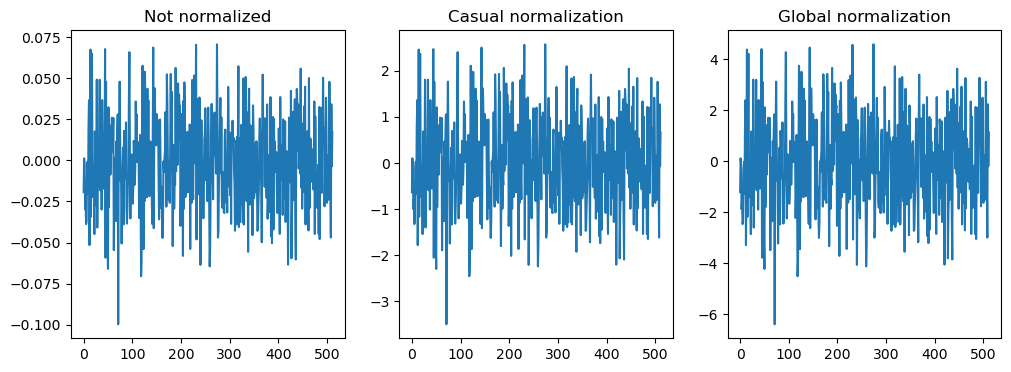

In [30]:
show_norm(test_encoded)